In [15]:
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score, accuracy_score
import os
from datetime import datetime
from tqdm import tqdm
from PIL import Image
from skimage.io import imread, imsave
from ModelArchitecture.DiceLoss import dice_metric_loss

In [17]:
required_dirs = [
    "results",
    "author_resized_data/test",
    "plots",
]

for dir in required_dirs:
    if not os.path.exists(dir):
        os.makedirs(dir)

resized_datasets = {
    "Kvasir-SEG": {
        "image_dir": "author_resized_data/Kvasir-SEG/test/images",
        "mask_dir": "author_resized_data/Kvasir-SEG/test/masks",
    },
    "CVC-ClinicDB": {
        "image_dir": "author_resized_data/CVC-ClinicDB/test/images",
        "mask_dir": "author_resized_data/CVC-ClinicDB/test/masks",
    },
    "CVC-ColonDB": {
        "image_dir": "author_resized_data/CVC-ColonDB/test/images",
        "mask_dir": "author_resized_data/CVC-ColonDB/test/masks",
    },
    "ETIS-LaribpolypDB": {
        "image_dir": "author_resized_data/ETIS-LaribpolypDB/test/images",
        "mask_dir": "author_resized_data/ETIS-LaribpolypDB/test/masks",
    },
}

for dataset_name, dataset_paths in resized_datasets.items():
    if not os.path.exists(dataset_paths["image_dir"]):
        os.makedirs(dataset_paths["image_dir"])
    if not os.path.exists(dataset_paths["mask_dir"]):
        os.makedirs(dataset_paths["mask_dir"])

In [18]:
# Define function to save and load numpy arrays
def save_numpy_arrays(images, masks, dataset_name):
    np.save(f"author_resized_data/test/{dataset_name}_images.npy", images)
    np.save(f"author_resized_data/test/{dataset_name}_masks.npy", masks)


def load_numpy_arrays(dataset_name):
    images = np.load(f"author_resized_data/test/{dataset_name}_images.npy")
    masks = np.load(f"author_resized_data/test/{dataset_name}_masks.npy")
    return images, masks


# Define function to load data and resize images and masks
def load_data(image_dir, mask_dir, img_height, img_width, images_to_be_loaded, dataset_name):

    # Check if the resized data already exists
    if os.path.exists(f"author_resized_data/test/{dataset_name}_images.npy") and os.path.exists(f"author_resized_data/test/{dataset_name}_masks.npy"):
        print(f"Loading preprocessed data for {dataset_name}")
        return load_numpy_arrays(dataset_name)

    # The authors have already converted all images to .jpg
    test_ids = glob.glob(f"{image_dir}/*.jpg")

    print(test_ids)

    if images_to_be_loaded == -1:
        images_to_be_loaded = len(test_ids)

    images = np.zeros((images_to_be_loaded, img_height, img_width, 3), dtype=np.float32)
    masks = np.zeros((images_to_be_loaded, img_height, img_width), dtype=np.uint8)

    print(f"Resizing training images and masks: {images_to_be_loaded}")
    for n, id_ in tqdm(enumerate(test_ids)):
        if n == images_to_be_loaded:
            break

        image_path = id_
        mask_path = image_path.replace("images", "masks")
        resized_image_path = image_path.replace("author_data", "author_resized_data")
        resized_mask_path = mask_path.replace("author_data", "author_resized_data")

        # Check if the image has been resized
        if os.path.exists(resized_image_path) and os.path.exists(resized_mask_path):
            image = imread(resized_image_path)
            mask_ = imread(resized_mask_path)
        else:
            image = imread(image_path)
            mask_ = imread(mask_path)

            pillow_image = Image.fromarray(image)
            pillow_image = pillow_image.resize((img_height, img_width))
            image = np.array(pillow_image)
            imsave(resized_image_path, image)

            pillow_mask = Image.fromarray(mask_)
            pillow_mask = pillow_mask.resize((img_height, img_width), Image.Resampling.LANCZOS)
            mask_ = np.array(pillow_mask)
            imsave(resized_mask_path, mask_)

        images[n] = image / 255.0

        mask = np.zeros((img_height, img_width), dtype=np.bool_)
        for i in range(img_height):
            for j in range(img_width):
                if np.any(mask_[i, j] >= 127):
                    mask[i, j] = 1

        masks[n] = mask

    masks = np.expand_dims(masks, axis=-1)

    # Save the preprocessed data
    save_numpy_arrays(images, masks, dataset_name)

    return images, masks

In [19]:
img_size = 352


# Define function to evaluate model
def evaluate_model(model_path, dataset_name, image_dir, mask_dir, desc=""):
    # Load data
    images, masks = load_data(image_dir, mask_dir, img_size, img_size, -1, dataset_name)

    # Load model
    model = tf.keras.models.load_model(model_path, custom_objects={"dice_metric_loss": dice_metric_loss})

    # Make predictions
    predictions = model.predict(images, batch_size=4)

    # Calculate metrics
    f1 = f1_score(np.ndarray.flatten(np.array(masks, dtype=bool)), np.ndarray.flatten(predictions > 0.5))
    jaccard = jaccard_score(np.ndarray.flatten(np.array(masks, dtype=bool)), np.ndarray.flatten(predictions > 0.5))
    precision = precision_score(np.ndarray.flatten(np.array(masks, dtype=bool)), np.ndarray.flatten(predictions > 0.5))
    recall = recall_score(np.ndarray.flatten(np.array(masks, dtype=bool)), np.ndarray.flatten(predictions > 0.5))
    accuracy = accuracy_score(np.ndarray.flatten(np.array(masks, dtype=bool)), np.ndarray.flatten(predictions > 0.5))

    # Print results
    print(f"Results for {dataset_name} using model {model_path}:")
    print(f"F1 Score: {f1}")
    print(f"Jaccard Score: {jaccard}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")

    # Save results to file
    result_file = f"{desc}-{os.path.basename(model_path)}_{dataset_name}.txt"
    with open(result_file, "w") as f:
        f.write(f"F1 Score: {f1}\n")
        f.write(f"Jaccard Score: {jaccard}\n")
        f.write(f"Precision: {precision}\n")
        f.write(f"Recall: {recall}\n")
        f.write(f"Accuracy: {accuracy}\n")

    return f1, jaccard, precision, recall, accuracy

In [20]:
# Define function to plot metrics and save the plots
def plot_metrics(metrics, dataset_name, model_name, save_dir, desc=""):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    plt.figure(figsize=(15, 5))

    for metric_name, metric_value in metrics.items():
        plt.bar(metric_name, metric_value, label=metric_name)

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title(f"Model {model_name} Metrics on {dataset_name} Testing Sets")
    plt.legend()

    # Generate a filename with datetime to avoid overwriting
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plot_filename = f"{desc}-{model_name}_metrics_{timestamp}.png"
    plot_filepath = os.path.join(save_dir, plot_filename)

    plt.savefig(plot_filepath)
    plt.show()

    print(f"Plot saved to {plot_filepath}")

Using model kvasir-17 to evaluate Kvasir-SEG testing set...
Loading preprocessed data for Kvasir-SEG
25/25 [==============================] - 7s 130ms/step
Results for Kvasir-SEG using model saved_model/kvasir-17:
F1 Score: 0.9380582501367194
Jaccard Score: 0.8833424717104206
Precision: 0.9398199834647902
Recall: 0.9363031093417531
Accuracy: 0.9800811111828512


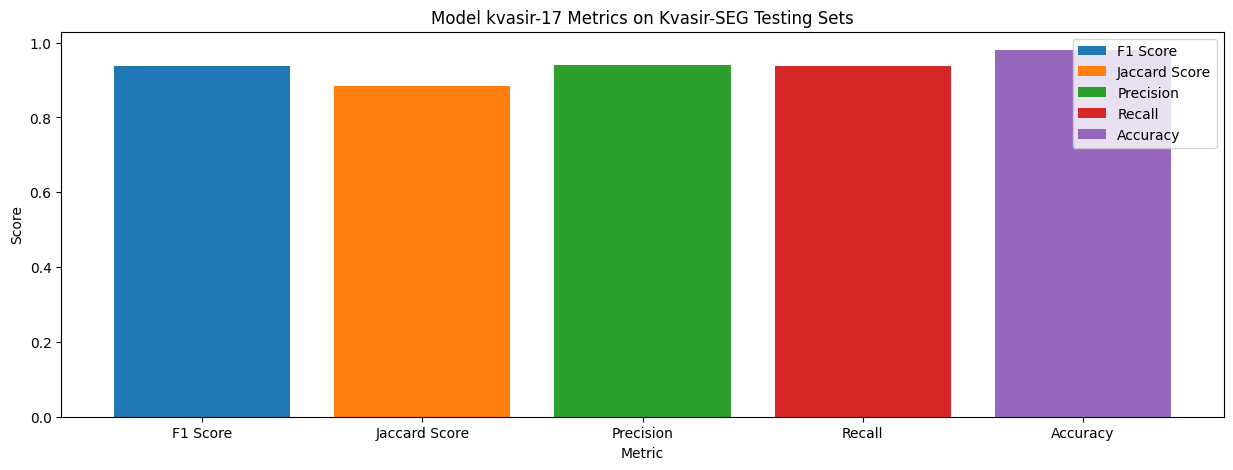

Plot saved to plots\Reproduce_Thesis-kvasir-17_metrics_20240522_170915.png
Using model kvasir-34 to evaluate Kvasir-SEG testing set...
Loading preprocessed data for Kvasir-SEG
25/25 [==============================] - 9s 221ms/step
Results for Kvasir-SEG using model saved_model/kvasir-34:
F1 Score: 0.9462526552467069
Jaccard Score: 0.8979881752093494
Precision: 0.95391804314478
Recall: 0.9387094786300079
Accuracy: 0.9828218620867769


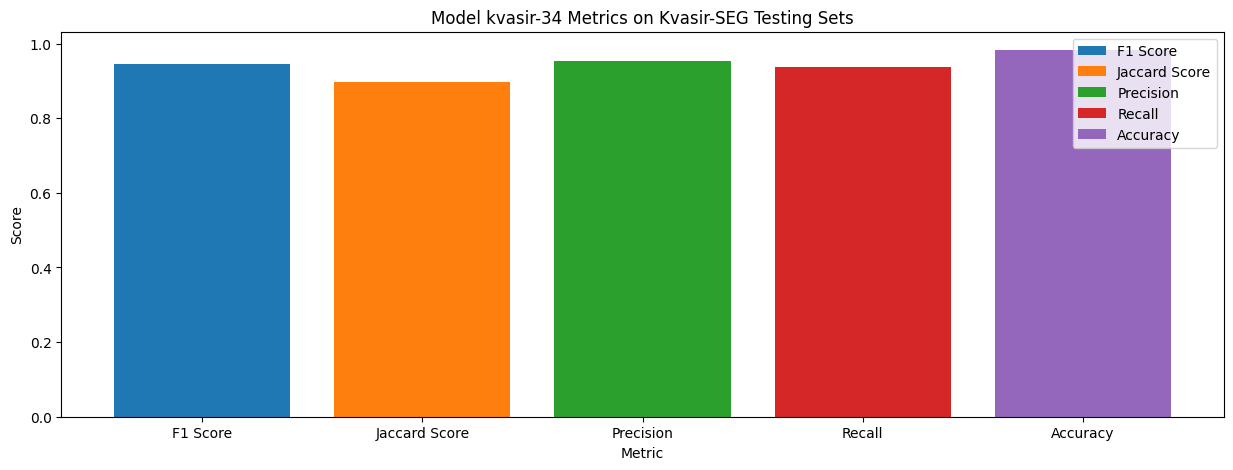

Plot saved to plots\Reproduce_Thesis-kvasir-34_metrics_20240522_171004.png
Using model cvc-clinicdb-17 to evaluate CVC-ClinicDB testing set...
Loading preprocessed data for CVC-ClinicDB
16/16 [==============================] - 5s 117ms/step
Results for CVC-ClinicDB using model saved_model/cvc-clinicdb-17:
F1 Score: 0.9450711687367411
Jaccard Score: 0.8958624892307046
Precision: 0.947132231625281
Recall: 0.9430190565650994
Accuracy: 0.9903232835827113


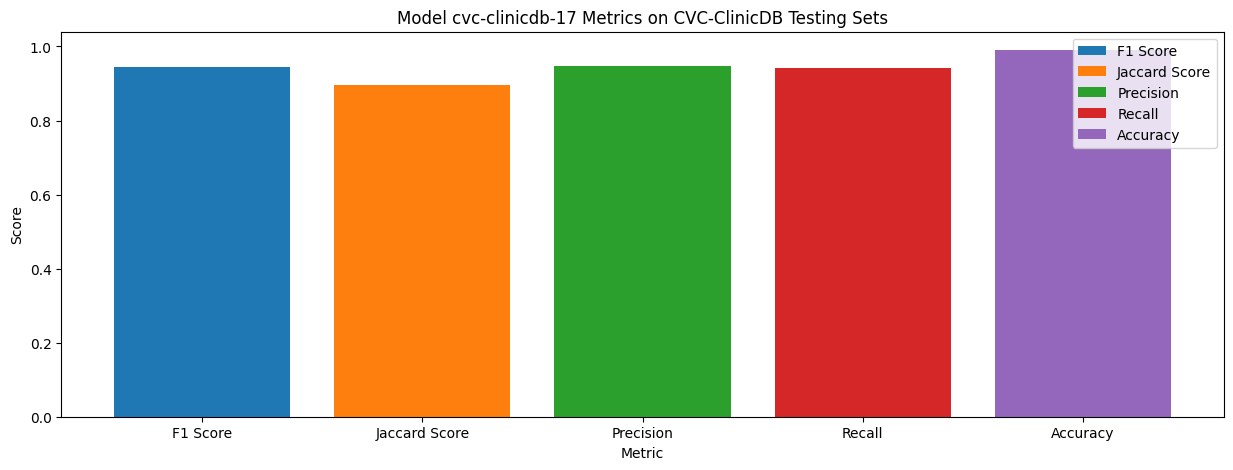

Plot saved to plots\Reproduce_Thesis-cvc-clinicdb-17_metrics_20240522_171044.png
Using model cvc-clinicdb-34 to evaluate CVC-ClinicDB testing set...
Loading preprocessed data for CVC-ClinicDB
16/16 [==============================] - 7s 225ms/step
Results for CVC-ClinicDB using model saved_model/cvc-clinicdb-34:
F1 Score: 0.9463642061219867
Jaccard Score: 0.8981891196376285
Precision: 0.9441764067818503
Recall: 0.9485621679331229
Accuracy: 0.9905085206444948


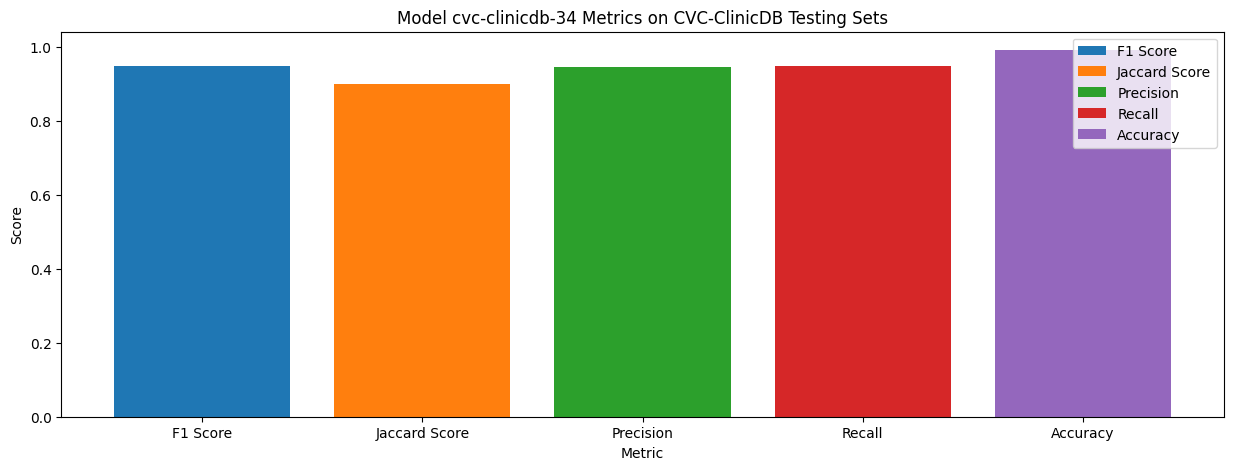

Plot saved to plots\Reproduce_Thesis-cvc-clinicdb-34_metrics_20240522_171127.png
Using model cvc-colondb-17 to evaluate CVC-ColonDB testing set...
Loading preprocessed data for CVC-ColonDB
10/10 [==============================] - 5s 127ms/step
Results for CVC-ColonDB using model saved_model/cvc-colondb-17:
F1 Score: 0.9390368911909083
Jaccard Score: 0.8850796822190705
Precision: 0.934932139941152
Recall: 0.9431778446045178
Accuracy: 0.9933055132666376


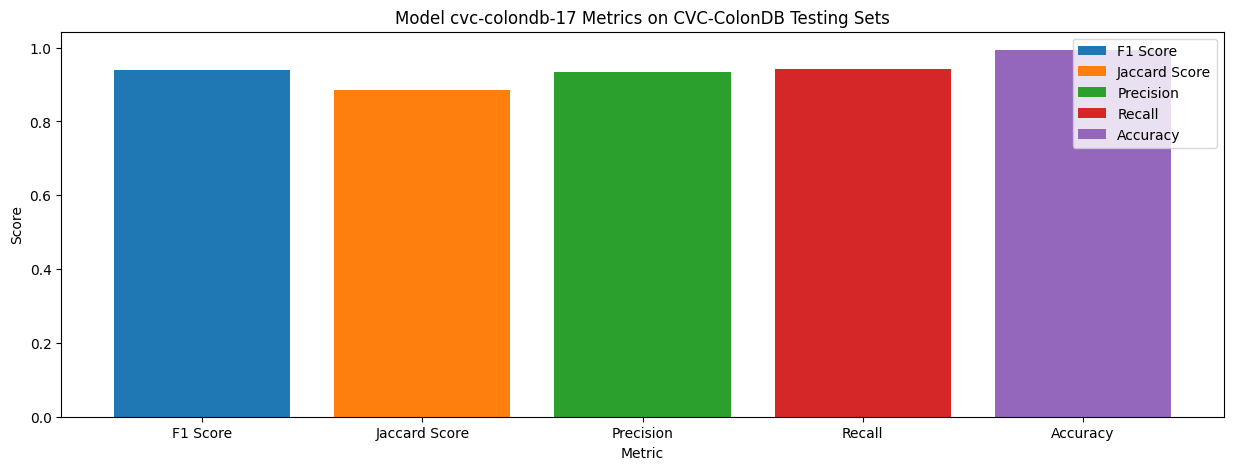

Plot saved to plots\Reproduce_Thesis-cvc-colondb-17_metrics_20240522_171204.png
Using model cvc-colondb-34 to evaluate CVC-ColonDB testing set...
Loading preprocessed data for CVC-ColonDB
10/10 [==============================] - 6s 220ms/step
Results for CVC-ColonDB using model saved_model/cvc-colondb-34:
F1 Score: 0.9221512336920258
Jaccard Score: 0.8555478862315077
Precision: 0.9103512504637657
Recall: 0.9342611371424575
Accuracy: 0.991377025337103


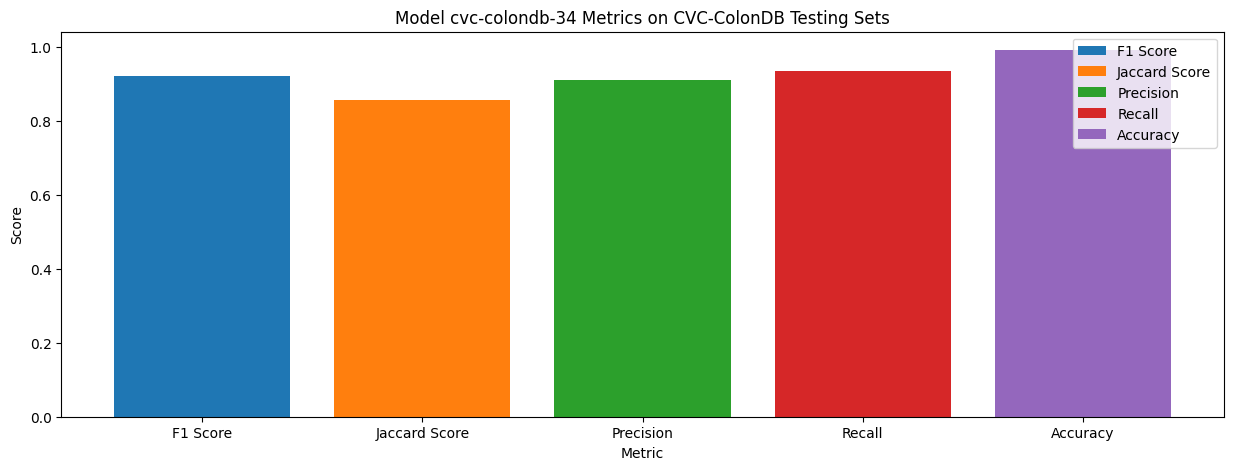

Plot saved to plots\Reproduce_Thesis-cvc-colondb-34_metrics_20240522_171243.png
Using model etis-laribpolypdb-17 to evaluate ETIS-LaribpolypDB testing set...
Loading preprocessed data for ETIS-LaribpolypDB
5/5 [==============================] - 4s 131ms/step
Results for ETIS-LaribpolypDB using model saved_model/etis-laribpolypdb-17:
F1 Score: 0.9326561809701419
Jaccard Score: 0.8738104482751042
Precision: 0.9546509580445327
Recall: 0.9116520808652119
Accuracy: 0.993049054106405


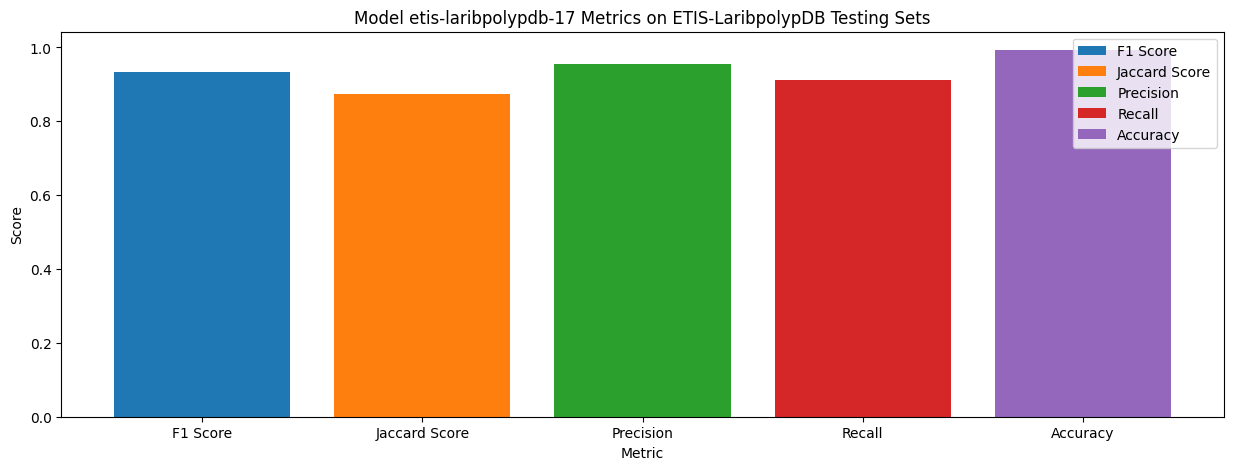

Plot saved to plots\Reproduce_Thesis-etis-laribpolypdb-17_metrics_20240522_171320.png
Using model etis-laribpolypdb-34 to evaluate ETIS-LaribpolypDB testing set...
Loading preprocessed data for ETIS-LaribpolypDB
5/5 [==============================] - 5s 283ms/step
Results for ETIS-LaribpolypDB using model saved_model/etis-laribpolypdb-34:
F1 Score: 0.927696819446124
Jaccard Score: 0.8651441460492
Precision: 0.9175095123829173
Recall: 0.9381128902816525
Accuracy: 0.9922795067148761


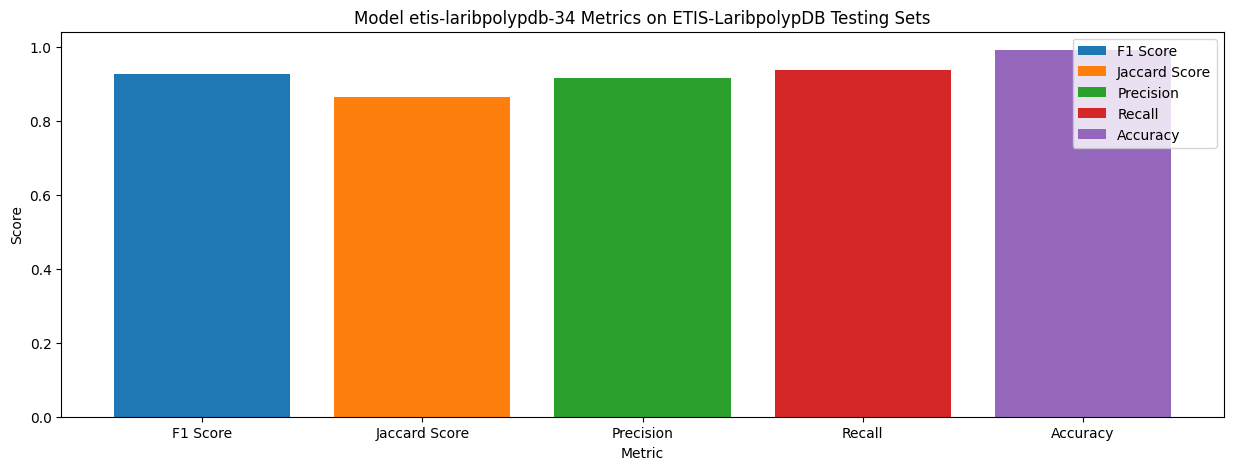

Plot saved to plots\Reproduce_Thesis-etis-laribpolypdb-34_metrics_20240522_171356.png


In [21]:
# Define datasets and models

models = [
    "saved_model/kvasir-17",
    "saved_model/kvasir-34",
    "saved_model/cvc-clinicdb-17",
    "saved_model/cvc-clinicdb-34",
    "saved_model/cvc-colondb-17",
    "saved_model/cvc-colondb-34",
    "saved_model/etis-laribpolypdb-17",
    "saved_model/etis-laribpolypdb-34",
]

author_testsets = {
    "Kvasir-SEG": {
        "image_dir": "author_data/Kvasir-SEG/test/images",
        "mask_dir": "author_data/Kvasir-SEG/test/masks",
    },
    "CVC-ClinicDB": {
        "image_dir": "author_data/CVC-ClinicDB/test/images",
        "mask_dir": "author_data/CVC-ClinicDB/test/masks",
    },
    "CVC-ColonDB": {
        "image_dir": "author_data/CVC-ColonDB/test/images",
        "mask_dir": "author_data/CVC-ColonDB/test/masks",
    },
    "ETIS-LaribpolypDB": {
        "image_dir": "author_data/ETIS-LaribPolypDB/test/images",
        "mask_dir": "author_data/ETIS-LaribPolypDB/test/masks",
    },
}

# Directory to save the plots
plot_save_dir = "plots"


# Evaluate models on different datasets
for model_path in models:

    for dataset_name, dataset_paths in author_testsets.items():

        # "CVC-ColonDB" "saved_model/cvc-clinicdb-17"
        # "colondb" != "clinicdb"

        if dataset_name.split("-")[0] == "CVC":
            if dataset_name.split("-")[1].lower() != model_path.split("/")[-1].split("-")[-2].lower():
                continue
        elif dataset_name.split("-")[0].lower() != model_path.split("/")[-1].split("-")[0].lower():
            continue

        print(f"Using model {os.path.basename(model_path)} to evaluate {dataset_name} testing set...")

        metrics = {
            "F1 Score": [],
            "Jaccard Score": [],
            "Precision": [],
            "Recall": [],
            "Accuracy": [],
        }

        image_dir = dataset_paths["image_dir"]
        mask_dir = dataset_paths["mask_dir"]

        f1, jaccard, precision, recall, accuracy = evaluate_model(model_path, dataset_name, image_dir, mask_dir, desc="Reproduce_Thesis")

        metrics["F1 Score"].append(f1)
        metrics["Jaccard Score"].append(jaccard)
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["Accuracy"].append(accuracy)

        # Plot metrics
        plot_metrics(metrics, dataset_name, os.path.basename(model_path), plot_save_dir, desc="Reproduce_Thesis")